# Milestone - Random Forets

## Part 1 - Feedback responses (only if required)

## Part 2 - Milestone 3

### 1. Data importing

In [36]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import warnings

The first step consists on importing the csv fieles for train and test dataset, as they were already divided in the previous preprocessing steps.

In [2]:
# Import train and test datasets in csv format
data_train = pd.read_csv('OpenData/ames_train_clean.csv')
data_test = pd.read_csv('OpenData/ames_test_clean.csv')

As a second step, we will connvert the train and test datasets into NumPy arrays, extracting also the variables' names as an independent vector.

In [38]:
# Creating numpy arrays for X and Y
X_train = data_train.drop(columns = ['PID', 'SoldPrice']).values
X_test = data_test.drop(columns = ['PID', 'SoldPrice']).values
X_names = data_train.drop(columns = ['PID', 'SoldPrice']).columns.tolist()

Y_train = data_train['SoldPrice'].values.reshape(-1,1)
Y_test = data_test['SoldPrice'].values.reshape(-1,1)

In [42]:
# Creating datasets
X_train = data_train.drop(columns = ['PID', 'SoldPrice'])
X_test = data_test.drop(columns = ['PID', 'SoldPrice'])
X_names = data_train.drop(columns = ['PID', 'SoldPrice']).columns.tolist()

Y_train = data_train['SoldPrice']
Y_test = data_test['SoldPrice']

### 2. Hyperparameter tuning
Recall what are the two most important hyperparameters. Propose a protocol that relies on the out-of-bag (OOB) error to tune this hyperparameter.

Based on our datase, we will apply a random forest model to predict the properties' sold price, as we did previously with the regression models. For this, as we have a regression problem, we will use the scikit function RandomForestRegressor()

The random forest model requires tuning two main parameters:

- **n_estimators:** number of trees in the forest
- **max_features:** number of features to take into account when looking for the best split

The tuning will be done in two steps: 

First we will tune the n_estimators parameter, with max_features=None.
Once we have found the n_estimators optimal parameter, we will tune max_features using gridsearchCV to find the value that gives the best performance. 
Finally we will check again the n_estimators parameter, with the newly defined max_features, to see if an adjustment is necessary.

#### 2.1. Tuning n_estimators
We will first tune the n_estimators paramater. For this step, max_features is to None, which will consider the total number of variables. 

We will calculate the OOB error for random forest models with different numbers of trees, from a minimum of 100 to a maximum of 1500 in steps of 50. Finally, the OOB error will be plotted for each n_estimators tested value for visually inspecting at which value the error stabilizes.

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


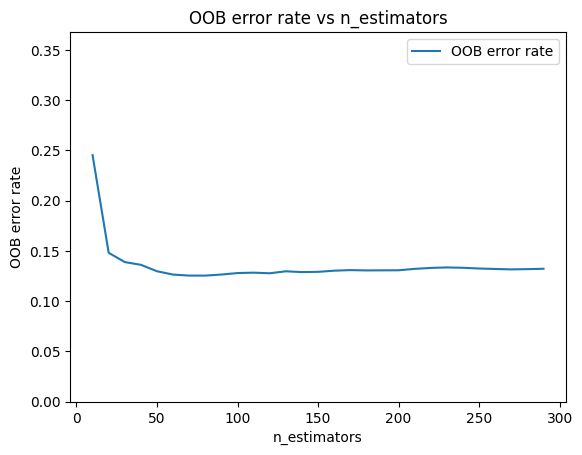

In [33]:
# Create an empty list for OBB error and i values iteration
error_rate = []
i_list = []

# Define a loop to iterate over the different values of n_estimators
for i in range(10, 300, 10):
    # warm_start = true: reuse the solution of the previous iteration, adding more estimators (otherwise a whole neww tree would be created)
    # random_state = 33: allows reproducibility, giving the same reuslts each time the notebook is ran
    # oob_score = true: sets oob score as the metric for generalisation score
    rf = RandomForestRegressor(warm_start=True, n_estimators=i, max_features=None, random_state=33, oob_score=True)
    rf.fit(X_train, Y_train)

    # oob_score attribute returns the accuracy, but we are interested on the error itself (then: 1-oob_score)
    oob_error = 1 - rf.oob_score_

    # Append OOB error rate and i values to the lists
    error_rate.append(oob_error)
    i_list.append(i)
  

# Plot n_esitmators vs OOB error

plt.plot(i_list, error_rate, label="OOB error rate")
plt.ylim(0, 1.5*max(error_rate)) 
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs n_estimators")
plt.legend(loc="upper right")
plt.show()

Based on the obtained graphic, we can conclude that the OOB error gets stabilized when n_estimators reaches 50. Consequently, we will use this value for the model.

#### 2.2 Tuning max_features
Once we have tuned the n_estimators parameter, we will use the selected value for tuning the max_features parameter. 

We will tune this parameter using Cross Validation technique, with 3 k-folds, as is one of the most common standard k values used for this task. The Crossvalidaiton search is performed over 10 iterations, to obtain a more robust result and reduce the effect of randomness.



## CHECK THIS BELOW, I HAVE MY DOUBTS ABOUT WETHER TO USE CV WITH MEAN TEST SCORE OR OOB APPROACH TO TUNE THE PARAMETERS.

In [18]:
# Create a dict of possible max_features values
cv_vals = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# Define the model
# n_estimators=50 based on the previous parameter tuning step
# random_state = 33: allows reproducibility, giving the same reuslts each time the notebook is ran
rf = RandomForestRegressor(n_estimators=50, random_state=33)

# Define the number of CV iterations (it) 
it = 10
results_cv=pd.DataFrame()

for i in range(it):
    
    gridsearch_cv = GridSearchCV(estimator=rf, param_grid=cv_vals, cv=3)
    gridsearch_cv.fit(X_train, Y_train)
    if i==0: 
        results_cv=pd.DataFrame(gridsearch_cv.cv_results_)[["params","mean_test_score","std_test_score"]]
    else:
        results_cv["mean_test_score"]=results_cv["mean_test_score"]+pd.DataFrame(gridsearch_cv.cv_results_)["mean_test_score"]
        results_cv["std_test_score"]=results_cv["std_test_score"]+pd.DataFrame(gridsearch_cv.cv_results_)["std_test_score"]  
        
        

results_cv["mean_test_score"]=results_cv["mean_test_score"]/it
results_cv["std_score"]=results_cv["std_test_score"]/it 

KeyboardInterrupt: 

In [ ]:
# Step 3: get the best parameters (with the higher performance)
print(round(results_cv, 2))

                  params  mean_test_score  std_test_score
0  {'max_features': 0.1}             0.86            0.04
1  {'max_features': 0.2}             0.85            0.03
2  {'max_features': 0.3}             0.85            0.03
3  {'max_features': 0.4}             0.85            0.04
4  {'max_features': 0.5}             0.85            0.04
5  {'max_features': 0.6}             0.85            0.04
6  {'max_features': 0.7}             0.85            0.04
7  {'max_features': 0.8}             0.84            0.04
8  {'max_features': 0.9}             0.84            0.04


According to the results ontained with CrossValidation, we will tune the max_features parameter to 0.3. This is because 0.3 is, together with 0.2, one of the two values that show a better trade-off between mean test score and mean sandard deviation test score. Moreover, 1/3 of the data is generally considered as a good proportion for max features in random forest (Hastie, Tibshirani, & Friedman, 2009, p. 592).

#### 2.3. Re-testing n_estimators value
As the value of max_featureschanged, after tuning, from the one that was originally considered when tuning n_estimators, we will test again if n_estimators=50 is a good value for a random forest model with max_features=0.3

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


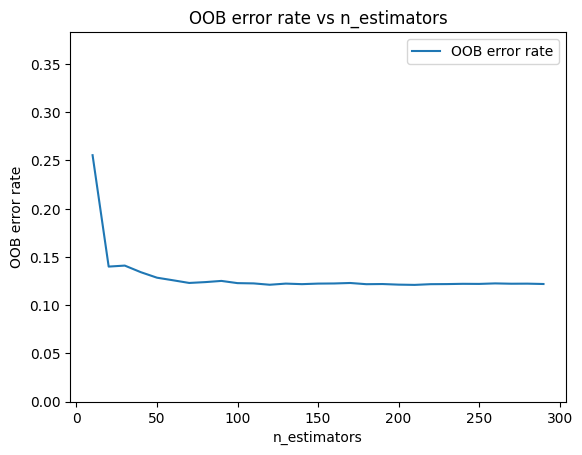

In [20]:
# Create an empty list for OBB error and i values iteration
error_rate = []
i_list = []

# Define a loop to iterate over the different values of n_estimators
for i in range(10, 300, 10):
    # We use the same configuration as in the tuning, but now max_features= 0.3
    rf = RandomForestRegressor(warm_start=True, n_estimators=i, max_features=0.3, random_state=33, oob_score=True)
    rf.fit(X_train, Y_train)

    # oob_score attribute returns the accuracy, but we are interested on the error itself (then: 1-oob_score)
    oob_error = 1 - rf.oob_score_

    # Append OOB error rate and i values to the lists
    error_rate.append(oob_error)
    i_list.append(i)
  

# Plot n_esitmators vs OOB error

plt.plot(i_list, error_rate, label="OOB error rate")
plt.ylim(0, 1.5*max(error_rate)) 
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs n_estimators")
plt.legend(loc="upper right")
plt.show()

We can see that, even after changing the max_features parameter value, n_estimators=50 seems to be small, to we will finally tune it to 75

#### 2.4. Applying the final Random Forest model
Now we will train athe final model, with the tuned hyperparameters and compute the OOB error

In [39]:
rf1 = RandomForestRegressor(n_estimators = 75, max_features= 0.3, oob_score=True, random_state=33)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
rf1.fit(X_train, Y_train)

c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features=0.3, n_estimators=75, oob_score=True,
                      random_state=33)

In [40]:
# OOB error
print(f'OOB error: {round(1-rf1.oob_score_, 2)}')

OOB error: 0.12


### 2. Measure the importance of variables
Once the final model is trained, we will analyze the importance of the different variables. For this we will use the Mean Decrease in Accuracy metric(MDA), which calculates the difference between the error of the forest on Tm and the error of the forestpermuted sample e T jm. We decide to use this metric instead of Gini Impurity, other popular metric, because MDA has been demonstrated to be more robust when fealling with variables of different scales and when there are correlations between predictive variables (Nicodemus, 2011 & Han et al. 2016). These two characteristics are present in our datasetm as it was analyzed in the EDA.

## CHECK N_REPEATS PARAM VALUE
## EDIT A BIT THIS CODE AS IT WAS TAKEN FROM AUDREYS NOTEBOOK (and maybe use other graph)


c:\Users\cande\anaconda3\envs\scientific\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


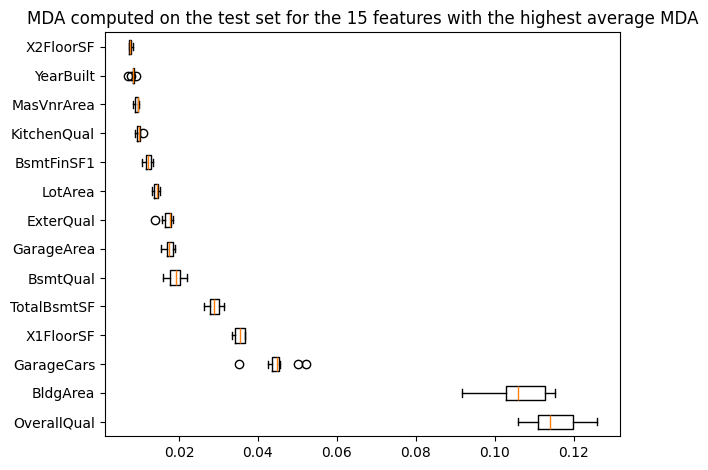

In [45]:

result = permutation_importance(rf1, X_train, Y_train, n_repeats=10, random_state=33, n_jobs=-1)

## Plot of the MDA for the 15 features with the highest average MDA
sorted_idx = result.importances_mean.argsort()
invert_sorted_idx=sorted_idx[::-1][:14]# keep only the 15 features with the highest average MDA
fig, ax = plt.subplots()
ax.boxplot(result.importances[invert_sorted_idx].T,
           vert=False, labels=X_train.columns[invert_sorted_idx])
ax.set_title("MDA computed on the test set for the 15 features with the highest average MDA")
fig.tight_layout()
plt.show()

### 3. Variable selection
Based on the feature importance analysis (previous question), conduct a selection of variables using one
of the strategies described during the lecture. Justify your choice and recall how the selected technique
works. Implement and run it. What is the final number of selected variables in the model? Justify if you
need to recalibrate the forest or not.

### 4. Evaluate test performance
Evaluate the test performance of the two random forest models (based on the full set of variables or a subset) and determine the configuration of the best model (based on the main evaluation metric you selected in step 1).

### References
Kristin K. Nicodemus, Letter to the Editor: On the stability and ranking of predictors from random forest variable importance measures, Briefings in Bioinformatics, Volume 12, Issue 4, July 2011, Pages 369–373, https://doi.org/10.1093/bib/bbr016

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer. URL: https://link.springer.com/book/10.1007/978-0-387-84858-7

Hong Han, Xiaoling Guo and Hua Yu, "Variable selection using Mean Decrease Accuracy and Mean Decrease Gini based on Random Forest," 2016 7th IEEE International Conference on Software Engineering and Service Science (ICSESS), Beijing, 2016, pp. 219-224, doi: 10.1109/ICSESS.2016.7883053.
